<a href="https://colab.research.google.com/github/manabil/Tensorflow-Advanced-Techniques-Specialization/blob/main/Advanced%20Computer%20Vision%20with%20Tensorflow/Week%201/C3_W1_Lab_2_Transfer_Learning_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Transfer Learning
In this notebook, you will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.



## Imports

In [1]:
import os
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


## Parameters

- Define the batch size
- Define the class (category) names

In [2]:
BATCH_SIZE: int = 32
classes: list = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

Define some functions that will help you to create some visualizations. (These will be used later)

In [38]:
#@title Visualization Utilities[RUN ME]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
# Matplotlib fonts
plt.rc('figure', facecolor='F0F0F0')
MATPLOTLIB_FONT_DIR: str = os.path.join(
    os.path.dirname(plt.__file__), "mpl-data/fonts/ttf"
)

# utility to display a row of digits with their predictions
def display_images(
    digits: np.ndarray,
    predictions: np.ndarray,
    labels: np.ndarray,
    title: str
) -> None:
    n: int = 10

    indexes: np.ndarray = np.random.choice(len(predictions), size=n)
    n_digits: np.ndarray = digits[indexes]
    n_predictions: np.ndarray = predictions[indexes]
    n_predictions = n_predictions.reshape((n,))

    fig: plt.Figure = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(10):
        fig.add_subplot(1, 10, i+1)
        class_index: np.uint8 = n_predictions[i]

    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name: str, title: str, ylim: int=5) -> None:
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(
        history.history['val_' + metric_name],
        color='green',
        label=f'val_{metric_name}'
    )

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. You will load the dataset from Keras.

In [17]:
training_images: np.ndarray
training_labels: np.ndarray
validation_images: np.ndarray
validation_labels: np.ndarray
(
    training_images, training_labels
) , (
    validation_images, validation_labels
) = tf.keras.datasets.cifar10.load_data()

training_images:  <class 'numpy.ndarray'>


### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

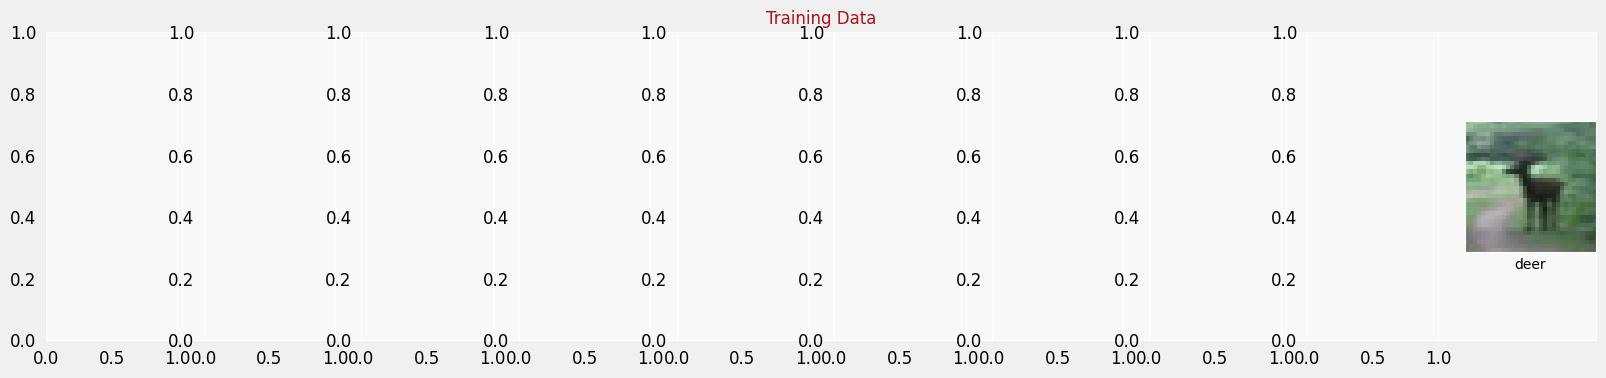

In [39]:
display_images(
    training_images, training_labels, training_labels, "Training Data"
)

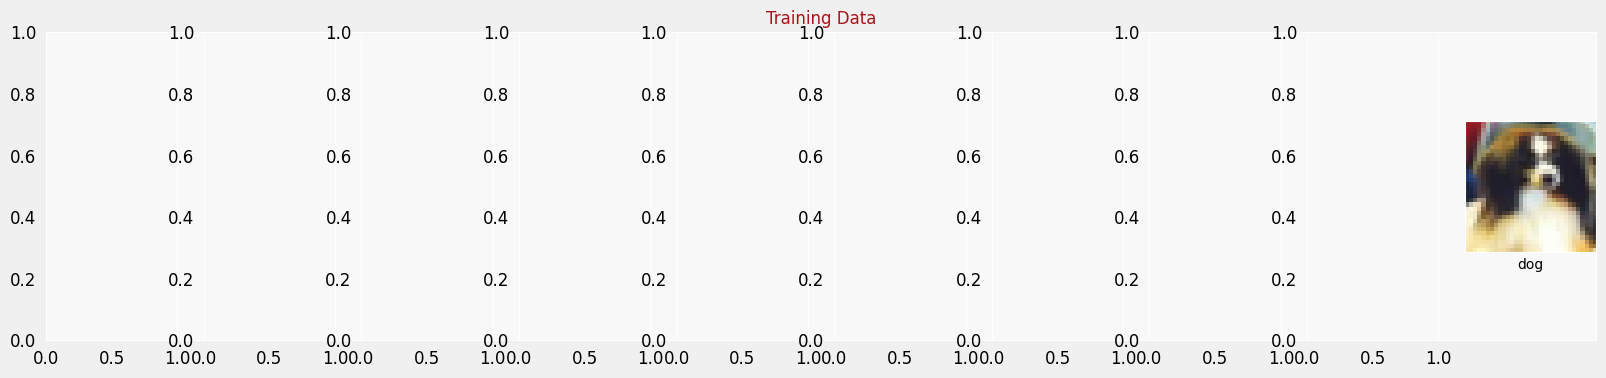

In [40]:
display_images(
    validation_images, validation_labels, validation_labels, "Training Data"
)

In [7]:
validation_images[0].astype('float32').shape

(32, 32, 3)

### Preprocess Dataset
Here, you'll perform normalization on images in training and validation set.
- You'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [27]:
def preprocess_image_input(input_images: np.ndarray) -> np.ndarray:
    input_images = input_images.astype('float32')
    output_ims: np.ndarray = tf.keras.applications.resnet50.preprocess_input(
        input_images
    )
    return output_ims


In [28]:
train_X: np.ndarray = preprocess_image_input(training_images)
valid_X: np.ndarray = preprocess_image_input(validation_images)

## Define the Network
You will be performing transfer learning on **ResNet50** available in Keras.
- You'll load pre-trained **imagenet weights** to the model.
- You'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [30]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs: tf.Tensor) -> tf.Tensor:
    feature_extractor: tf.Tensor = tf.keras.applications.resnet.ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet'
    )(inputs)

    return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs: tf.Tensor) -> tf.Tensor:
    x: tf.Tensor = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of
(7x7) to transform it to (224 x 224). Connect the feature extraction and
"classifier" layers to build the model.
'''
def final_model(inputs: tf.Tensor) -> tf.Tensor:
    resize: tf.Tensor = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor: tf.Tensor = feature_extractor(resize)
    classification_output: tf.Tensor = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model() -> tf.keras.Model:
    inputs: tf.Tensor = tf.keras.layers.Input(shape=(32,32,3))

    classification_output: tf.Tensor = final_model(inputs)
    model: tf.keras.Model = tf.keras.Model(
        inputs=inputs, outputs=classification_output
    )

    model.compile(
       optimizer='SGD',
        loss='sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model


model: tf.keras.Model = define_compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098

## Train the model

In [11]:
# this will take around 20 minutes to complete
EPOCHS: int = 4
history: tf.keras.callbacks.History = model.fit(
    train_X,
    training_labels,
    epochs=EPOCHS,
    validation_data=(valid_X, validation_labels),
    batch_size=64
)

Epoch 1/4
782/782 [==============================] - 578s 696ms/step - loss: 0.4072 - accuracy: 0.8681 - val_loss: 0.2239 - val_accuracy: 0.9248
Epoch 2/4
782/782 [==============================] - 540s 690ms/step - loss: 0.1029 - accuracy: 0.9666 - val_loss: 0.1947 - val_accuracy: 0.9356
Epoch 3/4
782/782 [==============================] - 526s 673ms/step - loss: 0.0366 - accuracy: 0.9895 - val_loss: 0.1756 - val_accuracy: 0.9464
Epoch 4/4
782/782 [==============================] - 539s 690ms/step - loss: 0.0136 - accuracy: 0.9970 - val_loss: 0.1628 - val_accuracy: 0.9529


## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [33]:
loss: float
accuracy: float
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 28s 180ms/step - loss: 2.6841 - accuracy: 0.0771


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

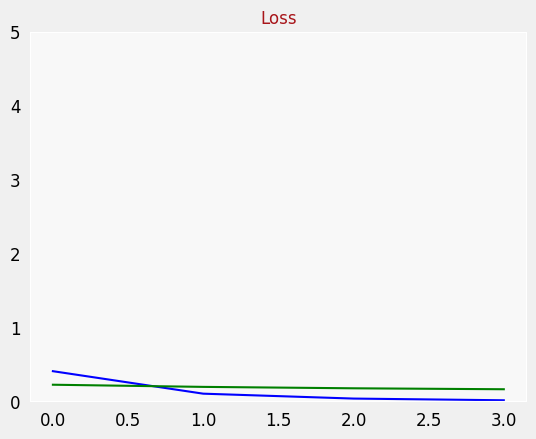

In [36]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

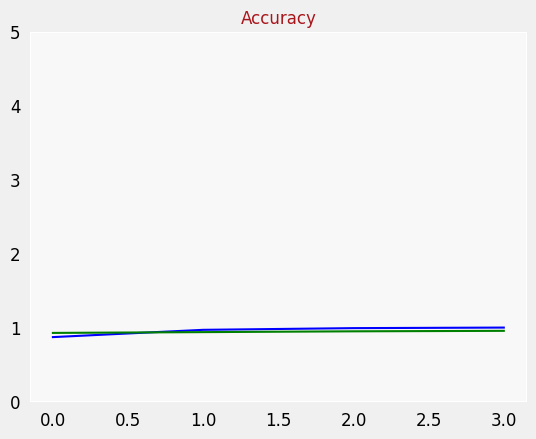

In [14]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions
You can take a look at the predictions on the validation set.

157/157 [==============================] - 28s 181ms/step


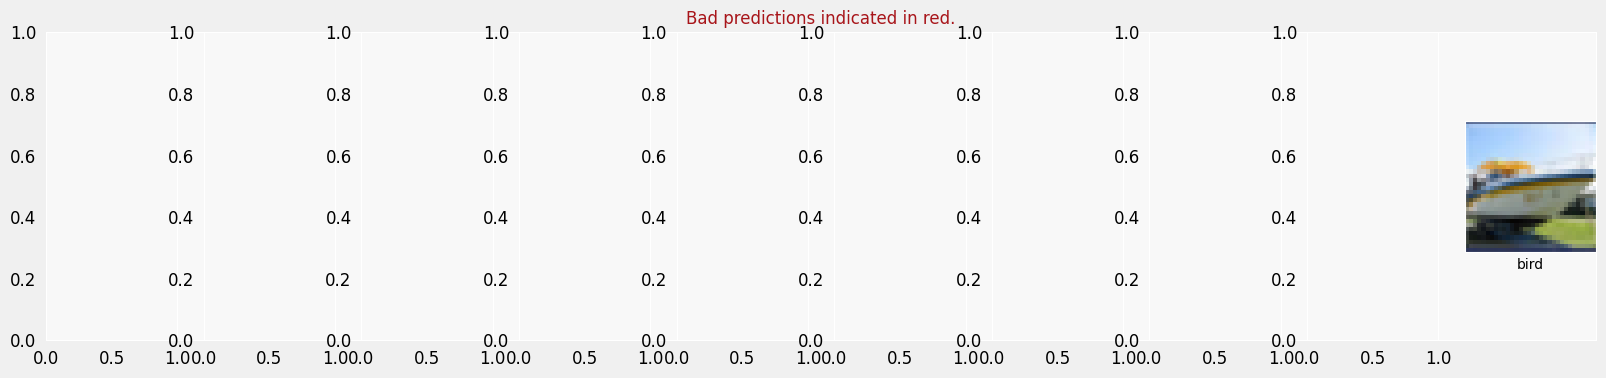

In [35]:
probabilities: np.ndarray = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(
    validation_images,
    probabilities,
    validation_labels,
    "Bad predictions indicated in red."
)